# Import all dependencies
For reference on how to install them visit their documentation online

In [1]:
from __future__ import division
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.nonparametric.kernel_regression import KernelReg
from numpy import linspace
import seaborn as sns

# Smoothin Factor
The Savitzy Golay smoothing factor, helps elimiate any extra noise in our data. Noise, in our case is the sharp market swings from low to highs and vice-versa. This is necessary as it makes our pattern detection task relatively easier.
Parameter definition:
1. y = data
2. window_size = length of candles for calculation of smoothness (higher the number the greater smoothing)

In [2]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')


# Dataframe Converter
If your data has random columns or columns with different name this function converts them to the OHLCV format. If there are dead days or zero volume days the function will drop the dataframe rows and set the index as the date.

In [6]:
def df_converter(csv):
    df = pd.read_csv(csv)
    df.columns = ['date','open','high','low','close','volume']
#     df['date'] = pd.to_datetime([x[:-21] for x in df['date'].squeeze().tolist()], dayfirst=True)
    df_vol = df.loc[(df.volume == 0)]
    df.drop(df_vol.index, axis = 0, inplace = True)
    df.set_index('date', inplace=True)
    return df
prices_ = df_converter('/home/user/Dropbox/CSV Files/EURUSD_HR.csv').close

In [9]:
smooth_prices = savitzky_golay(prices_,5,3)
smooth_prices = pd.DataFrame(smooth_prices,index = prices_.index)

# Smooth vs Price plot

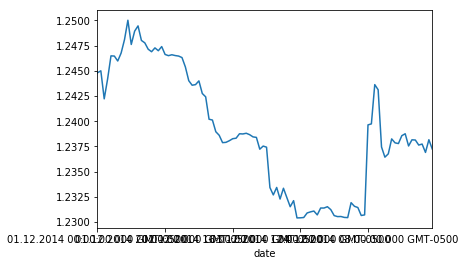

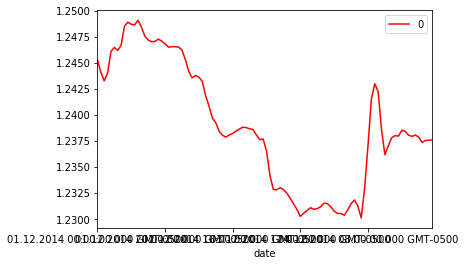

In [10]:
prices_.iloc[:100].plot()
smooth_prices.iloc[:100].plot(color='red')

# Finding local extremas (minima and maxima)
These points will serve as our starting and end points of our detected patterns

In [11]:
from scipy.signal import argrelextrema

In [12]:
local_max = argrelextrema(smooth_prices.values, np.greater)[0]
local_min = argrelextrema(smooth_prices.values, np.less)[0]

In [13]:
price_local_max_dt = []
for i in local_max:
    if (i>1) and (i<len(prices_)-1):
        price_local_max_dt.append(prices_.iloc[i-2:i+2].idxmax())

price_local_min_dt = []
for i in local_min:
    if (i>1) and (i<len(prices_)-1):
        price_local_min_dt.append(prices_.iloc[i-2:i+2].idxmax())

In [14]:
local_max = argrelextrema(smooth_prices.values, np.greater)[0]
local_min = argrelextrema(smooth_prices.values, np.less)[0]
local_max_dt = smooth_prices.iloc[local_max].index.values
local_min_dt = smooth_prices.iloc[local_min].index.values

# Finding Min Max
The above code can be neatly organized into a function and that way we have more code reusability. The function is basically smoothing prices, finding the local maxima and minima, appending it to the dataframe and returning the max_min values with the associated date index 

In [17]:
# Let's throw what we have so far into a function:
def find_max_min(prices):
    prices_ = prices.copy()
    smooth_prices = savitzky_golay(prices,15,3)
    smooth_prices = pd.DataFrame(smooth_prices,index = prices_.index)
    
    local_max = argrelextrema(smooth_prices.values, np.greater)[0]
    local_min = argrelextrema(smooth_prices.values, np.less)[0]
    
    price_local_max_dt = []
    for i in local_max:
        if (i>1) and (i<len(prices_)-1):
            price_local_max_dt.append(prices_.iloc[i-2:i+2].argmax())

    price_local_min_dt = []
    for i in local_min:
        if (i>1) and (i<len(prices_)-1):
            price_local_min_dt.append(prices_.iloc[i-2:i+2].argmin())
        
    prices_.name = 'price'
    maxima = pd.DataFrame(prices_.loc[price_local_max_dt])
    minima = pd.DataFrame(prices_.loc[price_local_min_dt])
    max_min = pd.concat([maxima, minima]).sort_index()
    max_min.index.name = 'date'
    max_min = max_min.reset_index()
    max_min = max_min[~max_min.date.duplicated()]
    p = prices.reset_index()
    max_min['day_num'] = p[p['date'].isin(max_min.date)].index.values
    max_min = max_min.set_index('day_num').price
    return max_min

In [18]:
max_min = find_max_min(prices_)

/home/robin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  del sys.path[0]
/home/robin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


# Finding Technical Patterns
To the fun part. Because we have no collected data of how humans percieve different patterns, it is important to hardcode the patterns. To have variability in the results and mimick human perception, you can play around the values to find patterns within a range, in our example for the sake of simplicity, we go with the default values. We also want our number of bars elapsed to stay wihtin an acceptable amount of days. So for our purpose, there needs to be a detection of a pattern within 35 days.

In [22]:
from collections import defaultdict

def find_patterns(max_min):
    patterns = list()

    for i in range(5, len(max_min)):
        window = max_min.iloc[i-5:i]

        # pattern must play out in less than 36 days
        if window.index[-1] - window.index[0] > 35:
            continue

        # Using the notation from the paper to avoid mistakes
        e1 = window.iloc[0]
        e2 = window.iloc[1]
        e3 = window.iloc[2]
        e4 = window.iloc[3]
        e5 = window.iloc[4]

        rtop_g1 = np.mean([e1,e3,e5])
        rtop_g2 = np.mean([e2,e4])
        # Head and Shoulders
        if (e1 > e2) and (e3 > e1) and (e3 > e5) and \
            (abs(e1 - e5) <= 0.015*np.mean([e1,e5])) and \
            (abs(e2 - e4) <= 0.015*np.mean([e1,e5])):
                patterns.append(('HS',window.index[0], window.index[-1],e1,e2,e3,e4,e5))

        # Inverse Head and Shoulders
        elif (e1 < e2) and (e3 < e1) and (e3 < e5) and \
            (abs(e1 - e5) <= 0.015*np.mean([e1,e5])) and \
            (abs(e2 - e4) <= 0.015*np.mean([e1,e5])):
                patterns.append(('IHS',window.index[0], window.index[-1],e1,e2,e3,e4,e5))

        # Broadening Top
        elif (e1 > e2) and (e1 < e3) and (e3 < e5) and (e2 > e4):
            patterns.append(('BTOP',window.index[0], window.index[-1],e1,e2,e3,e4,e5))

        # Broadening Bottom
        elif (e1 < e2) and (e1 > e3) and (e3 > e5) and (e2 < e4):
            patterns.append(('BBOT',window.index[0], window.index[-1],e1,e2,e3,e4,e5))

        # Triangle Top
        elif (e1 > e2) and (e1 > e3) and (e3 > e5) and (e2 < e4):
            patterns.append(('TTOP',window.index[0], window.index[-1],e1,e2,e3,e4,e5))

        # Triangle Bottom
        elif (e1 < e2) and (e1 < e3) and (e3 < e5) and (e2 > e4):
            patterns.append(('TBOT',window.index[0], window.index[-1],e1,e2,e3,e4,e5))

        # Rectangle Top
        elif (e1 > e2) and (abs(e1-rtop_g1)/rtop_g1 < 0.0080) and \
            (abs(e3-rtop_g1)/rtop_g1 < 0.0080) and (abs(e5-rtop_g1)/rtop_g1 < 0.0080) and \
            (abs(e2-rtop_g2)/rtop_g2 < 0.0080) and (abs(e4-rtop_g2)/rtop_g2 < 0.0080) and \
            (min(e1, e3, e5) > max(e2, e4)):

            patterns.append(('RTOP',window.index[0], window.index[-1],e1,e2,e3,e4,e5))

        # Rectangle Bottom
        elif (e1 < e2) and (abs(e1-rtop_g1)/rtop_g1 < 0.0080) and \
            (abs(e3-rtop_g1)/rtop_g1 < 0.0080) and (abs(e5-rtop_g1)/rtop_g1 < 0.0080) and \
            (abs(e2-rtop_g2)/rtop_g2 < 0.0080) and (abs(e4-rtop_g2)/rtop_g2 < 0.0080) and \
            (max(e1, e3, e5) > min(e2, e4)):
            patterns.append(('RBOT',window.index[0], window.index[-1],e1,e2,e3,e4,e5))
        
            
    return (patterns)

# Export Results for Machine learning Process
Now that we have a sample dataset, it is time to use machine learning to help us detect patterns automatically.

In [23]:
patterns = find_patterns(max_min)
dataset_pattern = pd.DataFrame(patterns,columns = ['Pattern_Name','DAY1','DAY2','E1','E2','E3','E4','E5'])
dataset_pattern['Days/Bars'] = abs(dataset_pattern.DAY2-dataset_pattern.DAY1)
dataset_pattern.drop(columns=['DAY1','DAY2'],inplace=True)
export_dataset = dataset_pattern.to_csv('technical_pattern_found.csv')